# Esplorazione nella distribuzione lessicale

Codice ispirato a [Baayen (2008:243-250)](https://www.cambridge.org/highereducation/books/analyzing-linguistic-data/B2AF752A30911F4144CA35E075C6B233#overview)

Qui osserveremo la distribuzione delle parole-tipo (type) in un testo (la *Divina Commedia*) e in un [corpus di commenti YouTube](https://www.clarin.si/repository/xmlui/handle/11356/1450#) annotati per Hate Speech Detection. Il corpus è stato leggermente modificato per: 1. normalizzare problemi di spaziatura mancante 2. eliminare gli handler degli utenti

In [163]:
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sns

sns.set_style("darkgrid")
rcParams['figure.figsize'] = 12,9

## La Divina Commedia

In [4]:
import spacy
from scipy import stats

Creiamo un tokenizzatore

In [126]:
nlp = spacy.blank("it")
nlp.max_length = 20833854

Apriamo il file

In [105]:
with open('../data/commedia_cleaned.txt') as f:
    commedia = f.read()
comm = nlp(commedia)

Il tokenizzatore di `spacy` ha individuato all'incirca 130.000 token

In [106]:
len(comm)

135533

Ora eliminiamo i caratteri di nuova riga e i segni di punteggiatura

In [107]:
import re
comm_toks = [c.lower_ for c in comm if not re.search(r'\n+', c.lower_) and not c.is_punct]

Rimangono circa 100.000 token

In [13]:
len(comm_toks)

101797

Creiamo un contatore per contare le frequenze delle parole-tipo (type)

In [165]:
from collections import Counter

c = Counter(comm_toks)
c.most_common(14)

[('e', 4065),
 ('che', 3697),
 ('la', 2360),
 ('a', 2045),
 ('di', 1897),
 ("l'", 1727),
 ('non', 1456),
 ('per', 1384),
 ('io', 1137),
 ('in', 1107),
 ('si', 1043),
 ("ch'", 1029),
 ('l', 951),
 ('le', 802)]

Questo è il codice che ho usato per calcolare la percentuale cumulativa dei primi *n* tipi di un testo

In [115]:
for i, (parola, freq) in enumerate(c.most_common(12), start=1):
    cum = sum([f[-1] for f in c.most_common(i)])
    perc = (cum / len(comm_toks) * 100)
    print(parola, freq, perc)

e 4065 3.993241451123314
che 3697 7.624979125121565
la 2360 9.94331856538012
a 2045 11.952218631197383
di 1897 13.815731308388262
l' 1727 15.512244958102892
non 1456 16.942542511075963
per 1384 18.302111064176742
io 1137 19.41903985382673
in 1107 20.50649822686327
si 1043 21.531086377791095
ch' 1029 22.541921667632643


Ora:
- trasformiamo i dati di frequenza in una tabella
- aggiungiamo 2 colonne con il logaritmo del rango e il logaritmo delle frequenze

Visualizziamo le prime 5 righe della tabella

In [167]:
import pandas as pd
import numpy as np


ranks = [i for i, _ in enumerate(c.most_common(), start=1)]
words = [w[0] for w in c.most_common()]
freqs = [w[1] for w in c.most_common()]

df = pd.DataFrame(data={'rank': ranks, 'freq': freqs, 'word': words})
df['log_rank'] = np.log(df['rank'])

df['log_freq'] = np.log(df['freq'])
df.head(10)

,rank,freq,word,log_rank,log_freq
0,1,4065,e,0.000000,8.310169
1,2,3697,che,0.693147,8.215277
2,3,2360,la,1.098612,7.766417
3,4,2045,a,1.386294,7.623153
4,5,1897,di,1.609438,7.548029
5,6,1727,l',1.791759,7.454141
6,7,1456,non,1.945910,7.283448
7,8,1384,per,2.079442,7.232733
8,9,1137,io,2.197225,7.036148
9,10,1107,in,2.302585,7.009409


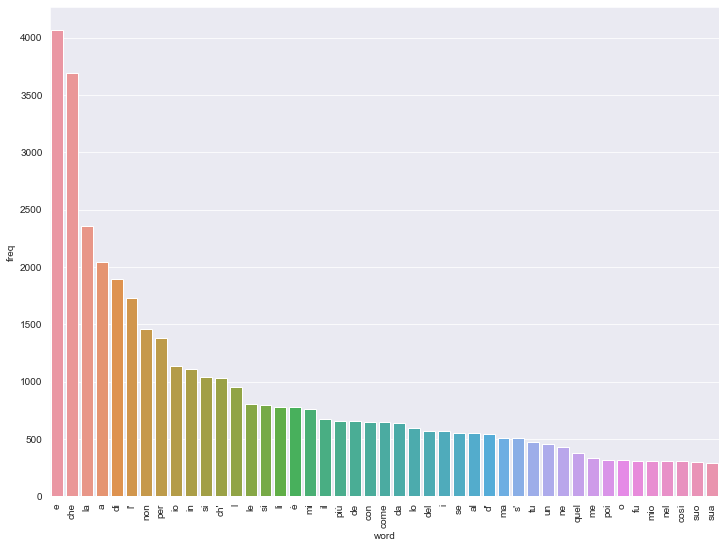

In [168]:
import seaborn as sns
from matplotlib import pyplot as plt

ax = sns.barplot(x='word', y='freq', data=df.iloc[:45])
#ax.set_xticklabels([w[0] for w in c.most_common(50)])
ax.tick_params(axis='x', rotation=90)
plt.show()

Qui creiamo il grafico in scala log/log, lasciando che una libreria python (`seaborn`) si occupi della regressione (disegnando la retta ideale)

<AxesSubplot:xlabel='log_rank', ylabel='log_freq'>

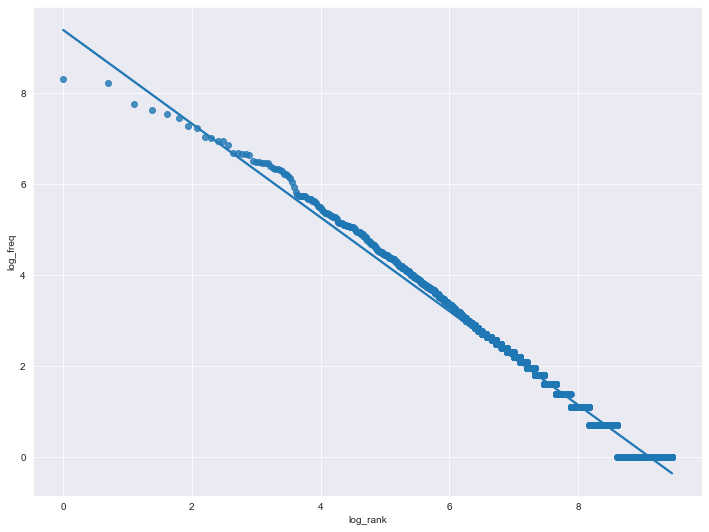

In [169]:
sns.regplot(data = df, x='log_rank', y='log_freq')

Possiamo avere informazioni più precise sulla pendenza e intercetto della regressione:

In [183]:
slope, intercept, r, p, std_err = stats.linregress(df.log_rank, df.log_freq)
print(slope)

-1.0301318191529754


## Il corpus di commenti su YouTube per la Hate Speech detection

Scaricato da [CLARIN](https://hdl.handle.net/11356/1450) e "normalizzato" leggermente (vedi sopra).

Per prima cosa, apriamo il file (compresso) TAR

In [176]:
import tarfile

tar = tarfile.open("../data/youtube_hate.tar.gz")
with tar.extractfile('youtube_hate.txt') as f:
    corpus = f.read().decode('utf8')
tar.close()

Ora facciamo la tokenizzazione! (potrebbe richiedere un po' di tempo)

In [179]:
toks = nlp(corpus)

Come prima per Dante, scartiamo i caratteri di nuova riga (\n) e la punteggiatura 

In [180]:
yt_toks = [c.lower_ for c in toks if not re.search(r'\n+', c.lower_) and c.is_alpha]
print(len(yt_toks))

3321631


Creiamo il contatore delle frequenze e vediamo le 20 parole più frequenti. Paragoniamole alle 20 più frequenti in Dante

In [182]:
cyt = Counter(yt_toks)
for yt, dante in zip(cyt.most_common(20), c.most_common(20)):
    print(f'{yt[0]} ({yt[1]})\t{dante[0]} ({dante[1]})')

e (96500)	e (4065)
che (91130)	che (3697)
di (86402)	la (2360)
non (66552)	a (2045)
il (58914)	di (1897)
la (58176)	l' (1727)
a (57302)	non (1456)
in (51056)	per (1384)
è (42212)	io (1137)
per (40912)	in (1107)
i (37894)	si (1043)
un (37506)	ch' (1029)
ma (30646)	l (951)
sono (27718)	le (802)
si (26882)	sì (796)
le (25108)	li (781)
da (22260)	è (778)
con (22098)	mi (760)
ci (20874)	il (671)
se (20158)	più (661)


## Esplorare le concordanze con `NLTK`

Esploriamo le conconrdanze del corpus di Hate Speech detection con la libreria che abbiamo già usato nella lezione sulla tokenizzazione, `NLTK`. NLTK offre una classe apposita (`Text`) per esplorare i dati testuali, utilizzando concordanze e collocazioni

In [184]:
from nltk import Text

Creiamo un'istanza della classe `Text` con la lista dei token del nostro corpus

In [185]:
t = Text(yt_toks)

E ora cerchiamo la chiave "buono"

In [186]:
t.concordance('buono')

Displaying 25 of 274 matches:
con voi bravi italia paese magnifico buono generoso che accoglie tutti no fa di
liate luce del sole vitaminad e cibo buono queste sono le prevenzioni da prende
egno che si dovrà pagare qualcosa di buono è capiamo di essere uno tutti colleg
ttata piuttosto che seguita nulla di buono arriverà dalla escluso giletti un ga
 dire che il coronavirus qualcosa di buono lo ha portato ci sta facendo capire 
hanno fatto mai niente di corretto o buono sono una razza di prevaricatori mand
nno la memoria corta dimenticando il buono ricevuto non sono gli italiani è que
non tu in particolare ma qualcosa di buono pensatene per giuoco almeno tre buon
a è servita a smantellare ciò che di buono aveva la scuola come rigore discipli
bravi persone che vogliono dare vita buono per russi italiani voi vivete buona 
uole soros grazie sei diventato così buono mmmmmm fammi state zitto va non pens
paura che avete diffuso voi vergogna buono a nulla presidente del coniglio dei 
io schiaca

Di default, il metodo che stampa le concordanze a video lavora con una finestra di 80 caratteri e mostra 25 righe. Possiamo modificare questi parametri:

In [188]:
t.concordance('buono', width=150, lines=30)

Displaying 30 of 274 matches:
ma avete specato core che dio sara con voi bravi italia paese magnifico buono generoso che accoglie tutti no fa diferente rase italia e una mamma che
rtificiale volte le quantità consigliate luce del sole vitaminad e cibo buono queste sono le prevenzioni da prendere e soprattutto stare calmi lo sta
lo ma questo è il sacrificio o il pegno che si dovrà pagare qualcosa di buono è capiamo di essere uno tutti collegati fisicamente a prescindere della
sta di parte faziosa andrebbe boicottata piuttosto che seguita nulla di buono arriverà dalla escluso giletti un galantuomo tutti gli altri sono fazio
i soffre per questa emergenza posso dire che il coronavirus qualcosa di buono lo ha portato ci sta facendo capire bene la pochezza della classe polit
entabile buona vita i tedeschi non hanno fatto mai niente di corretto o buono sono una razza di prevaricatori mandiamoli al diavolo insieme europa em
tratta di politica italiani però hanno la memoria corta dimenticando i

Possiamo anche cercare sequenze di più token

In [153]:
t.concordance(["nulla", 'di', "buono"])

Displaying 10 of 10 matches:
oicottata piuttosto che seguita nulla di buono arriverà dalla escluso giletti 
cazzo in anni non ci ha portato nulla di buono apparte debiti loro sono il ver
ria mi puzza parecchio non vedo nulla di buono mi spiace per i giovani che se 
isce unione europea non ha dato nulla di buono italia penso che italia possa r
a del signore non possiamo fare nulla di buono e naturalmente mettendoci il no
ria mi puzza parecchio non vedo nulla di buono mi spiace per i giovani che se 
oicottata piuttosto che seguita nulla di buono arriverà dalla escluso giletti 
isce unione europea non ha dato nulla di buono italia penso che italia possa r
cazzo in anni non ci ha portato nulla di buono apparte debiti loro sono il ver
a del signore non possiamo fare nulla di buono e naturalmente mettendoci il no


Ma come funziona la generazione delle concordanze? Il metodo genera un indice (`_concordance_list`) dell'istanza dove viene mappato ogni tipo alle sue posizioni nel testo.

Vediamo ad es. gli "offsets" (ovvero l'indice numerico) della parola "buono":

In [193]:
t._concordance_index._offsets['buono'][:5]

[75763, 78799, 84470, 87685, 94322]

Vediamo il primo:

In [194]:
print(yt_toks[75763])

buono


## Espressioni Regolari

`NLTK` mette a disposizione anche un interessante classe (`TokenSearcher`) per fare ricerche usando le espressioni regolari su una lista di token.
 
 La sintassi delle regex è la medesima che abbiamo visto a lezione, ma i token vanno scritti tra parentesi uncinate `<>`.

 Ad esempio: cerchiamo le sequenze *un buon x* o *una buona x* nel nostro corpus utilizzando le espressioni regolari

In [196]:
from nltk.text import TokenSearcher

In [197]:
tsearch =  TokenSearcher(yt_toks)
tsearch.findall('<un[ao]?><buon[ao]><.*>')

[['una', 'buona', 'occasione'],
 ['una', 'buona', 'salute'],
 ['una', 'buona', 'ragione'],
 ['una', 'buona', 'serata'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'cosa'],
 ['una', 'buona', 'guarigione'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'imunita'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'ragione'],
 ['una', 'buona', 'idea'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'idea'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'alimentazione'],
 ['uno', 'buono', 'da'],
 ['una', 'buona', 'giornata'],
 ['una', 'buona', 'leva'],
 ['una', 'buona', 'serata'],
 ['una', 'buona', 'vitaat'],
 ['una', 'buona', 'festa'],
 ['una', 'buona', 'serata'],
 ['una', 'buona', 'serata'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'parte'],
 ['una', 'buona', 'dose'],
 ['una', 'buona', 'volta'],
 ['una', 'buona', 'causa

Possiamo aggregare e contare i nomi per avere una specie di statistica:

In [200]:
res = tsearch.findall('<un[ao]?><buon[ao]>(<.*>)')
ctok = Counter([r[0] for r in res])
ctok.most_common(20)

[('parte', 34),
 ('volta', 24),
 ('serata', 22),
 ('giornata', 18),
 ('idea', 8),
 ('guarigione', 6),
 ('a', 6),
 ('notizia', 6),
 ('occasione', 4),
 ('ragione', 4),
 ('percentuale', 4),
 ('per', 4),
 ('scuola', 4),
 ('salute', 2),
 ('cosa', 2),
 ('imunita', 2),
 ('alimentazione', 2),
 ('da', 2),
 ('leva', 2),
 ('vitaat', 2)]